This is the first notebook from the Udemy course "Applied Machine Learning For Healthcare". Originally it was a notebook with Python version 2.7. My goal is not only to update the code for Python version 3.7 or to understand what has been done so far, but I want to add my own thoughts and eventually new code to the notebook, generally to understand the topic Breast Cancer Detection with SVM.

First of all, we have to import some libraries. I made sure that the Python version is 3.7 unlike in the Udemy course, when the instructor had version 2.7 for Python.

In [1]:
import sys
import scipy
import numpy as np
import matplotlib
import pandas as pd
import sklearn

print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pd.__version__))
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]
scipy: 1.4.1
numpy: 1.17.2
matplotlib: 3.1.1
pandas: 1.0.1
sklearn: 0.22.1


As we will use SVM, it will be easier to make use of the Scikit-Learn library, not only for the SVM itself, but also for the preprocessing and evaluation operations.

In [49]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

I made the work easier for myself by downloading the dataset file manually and moved it into the same folder, where this current notebook is. It was told that the following columns are existing in the .csv file.

In [19]:
# Load the dataset, original source is https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
columns = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
df = pd.read_csv('breast-cancer-wisconsin.data', names=columns)

The original notebook provided by Udemy declared that the value `?` exists at some places within the dataset. The Udemy instructor replaced the value by `-99999`. I asked myself why exactly `-99999` was taken to replace `?` values, because an attribute which has `?` value cannot be numeric. Replacing `?` by another categorical value does not make sense at all. 

I wanted to verify if `?` really appears in the dataset. It is the case. From all columns, I excluded the one containing numeric data in order to receive columns with categorical data. It shows that the column `bare_nuclei` is categorical.

In [20]:
if '?' in df.values:
    print('? exists in the dataframe.')
    
print(list(set(df.columns) - set(df._get_numeric_data().columns)))

? exists in the dataframe.
['bare_nuclei']


In [21]:
print(df.shape)

(699, 11)


As we see: 16 rows of data contain `?`, while we have overall 699 rows of data. We could actually try to exclude those data from further processing. An alternative approach is to actually not excluding the `?` value. Why not being honest? But let's try the first approach first.

In [22]:
df[df.values == '?']

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


In [23]:
df = df[df.bare_nuclei != '?']
print(df.shape)

(683, 11)


As `?` values are removed, we could actually convert the all values in the `bare_nuclei` column to numeric data.

In [24]:
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)
print("Number of non-numeric attributes in the dataframe: %d" % len(list(set(df.columns) - set(df._get_numeric_data().columns))))

Number of non-numeric attributes in the dataframe: 0


Now we can proceed with data preprocessing. As we are going for a detection task, it is clear that the `id` column will not be a selected feature to be learned. It will be dropped within the `df` variable, without creating a new variable by setting the parameter `inplace=True`.

In [25]:
df.drop(['id'], 1, inplace=True)
print(df.shape)

(683, 10)


Now let's take the first row of the dataframe as an example to look into:

In [26]:
# As a single data sample: Data from 0th row:
print(df.loc[0])

clump_thickness           5
uniform_cell_size         1
uniform_cell_shape        1
marginal_adhesion         1
single_epithelial_size    2
bare_nuclei               1
bland_chromatin           3
normal_nucleoli           1
mitoses                   1
class                     2
Name: 0, dtype: int64


By calling the `describe()` function, we can read descriptive column-wise statistics of the dataset: 
1. count (amount of non-NA observations): For all dependent and independent variables, the counted non-NA observation is 683.
2. mean
3. std (standard deviation)
4. min (minimum value): For all independent variables, the min value is 1.
5. 25%, 50%, 75% (percentile)
6. max (maximum value): For all independent variables, the max value is 10.

In [27]:
print(df.describe(include = 'all'))

       clump_thickness  uniform_cell_size  uniform_cell_shape  \
count       683.000000         683.000000          683.000000   
mean          4.442167           3.150805            3.215227   
std           2.820761           3.065145            2.988581   
min           1.000000           1.000000            1.000000   
25%           2.000000           1.000000            1.000000   
50%           4.000000           1.000000            1.000000   
75%           6.000000           5.000000            5.000000   
max          10.000000          10.000000           10.000000   

       marginal_adhesion  single_epithelial_size  bare_nuclei  \
count         683.000000              683.000000   683.000000   
mean            2.830161                3.234261     3.544656   
std             2.864562                2.223085     3.643857   
min             1.000000                1.000000     1.000000   
25%             1.000000                2.000000     1.000000   
50%             1.000000

Visualizing the data distribution in a histogram shows several findings:
1. We have only 2 classes, it is either class 2 or 4, which means we are dealing with a binary classification task. There are more observations for the class `2` (over 400) than `4` (approx. 250), which means the dataset is imbalanced. 
2. Most attributes such as `mitoses`, `single_epithelial_size`, `uniform_cell_size` have only a single peak in the data distribution.

According to this webpage from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)), class 2 stands for for benign, class 4 for malignant tumor.

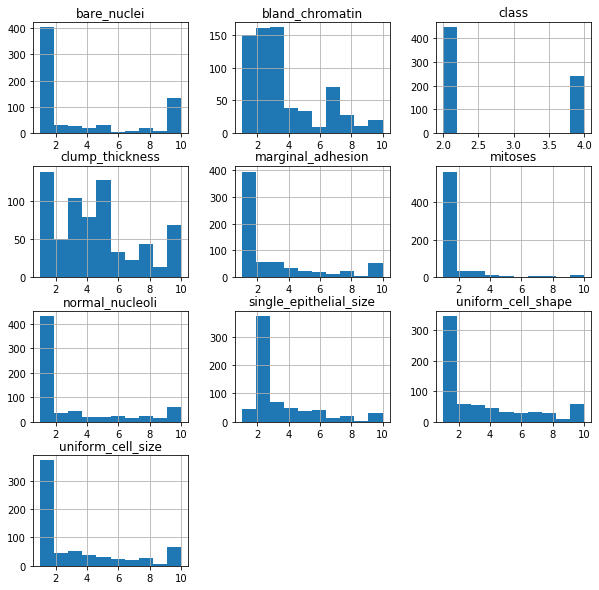

In [28]:
df.hist(figsize = (10, 10))
plt.show()

Before I started the breast cancer detection task, I had the opinion that scatter matrices are often very chaotic. After talking to my former thesis supervisor, he suggested me to look closer at the result. He pointed out that the features `uniform_cell_size` and `uniform_cell_shape` have a linear correlation, which is a super interesting point.

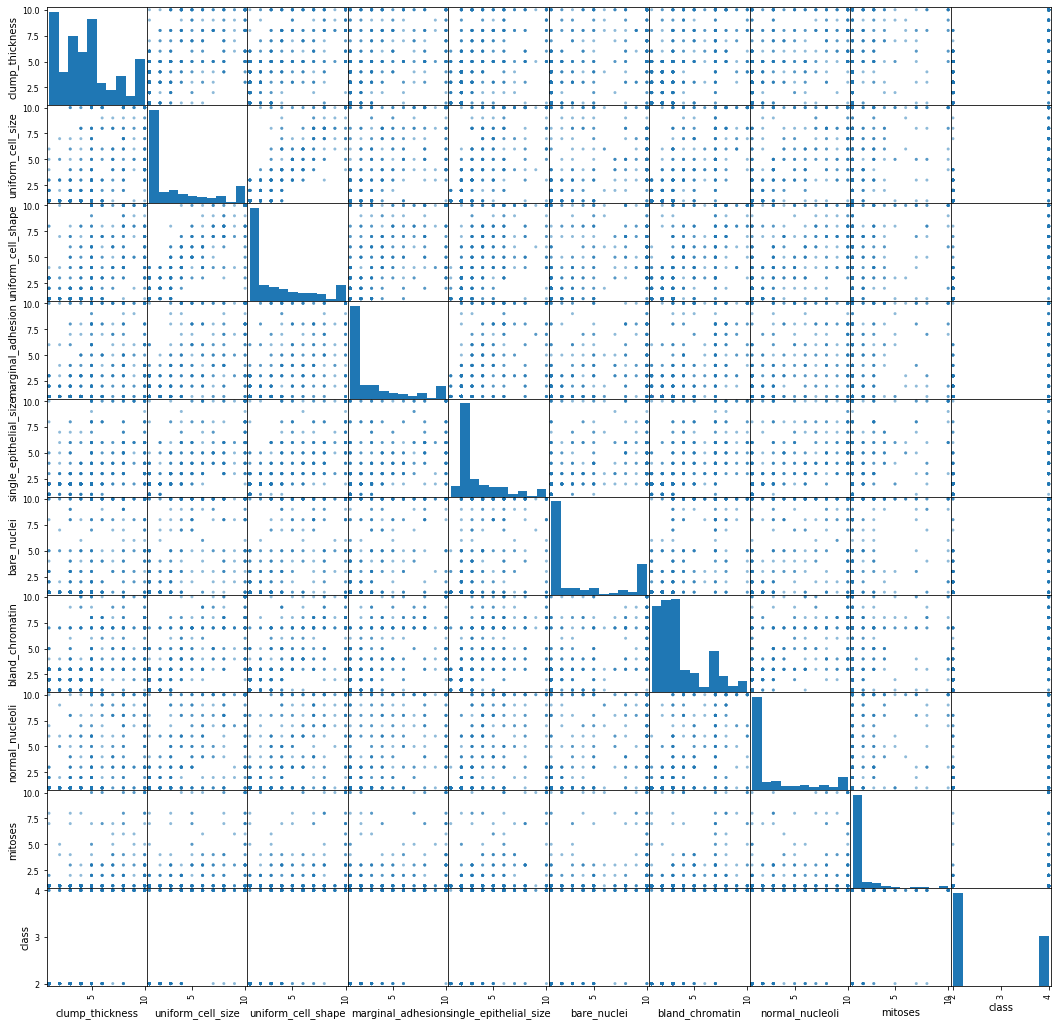

In [29]:
# Create scatter plot matrix
scatter_matrix(df, figsize = (18,18))
plt.show()

#### Machine Learning

After data cleaning/pre-processing and few visualizations, we can actually start doing the training. The Udemy course instructor suggested to use SVM and KNN classifiers, both can be used for simple datasets. As we have a binary classification task here and overall 683 data rows, both classifiers might actually work well. Especially, we have 9 independent variables and a binary dependent variable, also known as target variable. The target variable is either `2` or `4`, which we will transform into `0` and `1`.

In [67]:
# Create X and Y datasets for training
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])
y[y == 2] = 0 # benign tumor
y[y == 4] = 1 # malign tumor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Especially in case of medical datasets, it is highly important to not only rely on the overall accuracy, but also to have a look on the precision and recall scores, which can also be applied to receive the F1-score. They say a lot about the number of false positives and false negatives:
- `precision = tp / (tp + fp)` where `fp` stands for `false positive`.
- `recall = tp / (tp + fn)` where `fn` stands for `false negative`.

In [71]:
# Testing Options
seed = 8
scoring = ('accuracy', 'precision', 'recall', 'f1')

Applying KFold cross-validation is something I have only done once before. This time, I realized 

In [80]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 5)
kfold = model_selection.KFold(n_splits=10, random_state = seed)
cv_results = model_selection.cross_validate(knn, X_train, y_train, cv=kfold, scoring=scoring)

accuracy_msg = "%s: %f (%f)" % ('Accuracy', cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std())
precision_msg = "%s: %f (%f)" % ('Precision', cv_results['test_precision'].mean(), cv_results['test_precision'].std())
recall_msg = "%s: %f (%f)" % ('Recall', cv_results['test_recall'].mean(), cv_results['test_recall'].std())
f1_msg = "%s: %f (%f)" % ('F1-Score', cv_results['test_f1'].mean(), cv_results['test_f1'].std())
print(accuracy_msg)
print(precision_msg)
print(recall_msg)
print(f1_msg)

Accuracy: 0.968956 (0.021625)
Precision: 0.952708 (0.049037)
Recall: 0.956583 (0.031792)
F1-Score: 0.953921 (0.032738)


/Users/admin/enyangEnv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [81]:
# SVM
svc = SVC()
kfold = model_selection.KFold(n_splits=10, random_state = seed)
cv_results = model_selection.cross_validate(svc, X_train, y_train, cv=kfold, scoring=scoring)

accuracy_msg = "%s: %f (%f)" % ('Accuracy', cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std())
precision_msg = "%s: %f (%f)" % ('Precision', cv_results['test_precision'].mean(), cv_results['test_precision'].std())
recall_msg = "%s: %f (%f)" % ('Recall', cv_results['test_recall'].mean(), cv_results['test_recall'].std())
f1_msg = "%s: %f (%f)" % ('F1-Score', cv_results['test_f1'].mean(), cv_results['test_f1'].std())
print(accuracy_msg)
print(precision_msg)
print(recall_msg)
print(f1_msg)

Accuracy: 0.968923 (0.027224)
Precision: 0.939020 (0.059464)
Recall: 0.972188 (0.035972)
F1-Score: 0.954371 (0.040238)


/Users/admin/enyangEnv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [36]:
# Make predictions on validation dataset

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    
# Accuracy - ratio of correctly predicted observation to the total observations. 
# Precision - (false positives) ratio of correctly predicted positive observations to the total predicted positive observations
# Recall (Sensitivity) - (false negatives) ratio of correctly predicted positive observations to the all observations in actual class - yes.
# F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false 

KNN
0.9854014598540146
              precision    recall  f1-score   support

           2       0.99      0.99      0.99       100
           4       0.97      0.97      0.97        37

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137

SVM
1.0
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       100
           4       1.00      1.00      1.00        37

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137



In [37]:
clf = SVC()

clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

example_measures = np.array([[4,2,1,1,1,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

1.0
[2]
